In [64]:
import spcm
from spcm import units
import numpy as np
from atommover.utils import Move


def shape_linear(x):
    return x

def shape_cosine(x):
    return 0.5-0.5*np.cos(np.pi*x)

def shape_square(x):
    return np.where(x < 0.5, 0, 1)




class Serial_AOD_2D_DDS():
    def __init__(self, card: spcm.Card, core_number_x: int, core_number_y: int, f_list_x: np.ndarray, f_list_y: np.ndarray):
        self.card = card
        self.core_number_x = core_number_x
        self.core_number_y = core_number_y
        self.f_list_x = f_list_x
        self.f_list_y = f_list_y
        self.core_list_x = []
        self.core_list_y = []
        self.dds = None 
        self.card_setup()   
        self.allocate_cores()
    def allocate_cores(self):
        cores_y_available = [
            spcm.SPCM_DDS_CORE8, spcm.SPCM_DDS_CORE9, spcm.SPCM_DDS_CORE10, 
            spcm.SPCM_DDS_CORE11, spcm.SPCM_DDS_CORE20
        ]
        self.core_list_y = cores_y_available[-self.core_number_y:]
        cores_x_available = [
            spcm.SPCM_DDS_CORE0, spcm.SPCM_DDS_CORE1, spcm.SPCM_DDS_CORE2,                      
            spcm.SPCM_DDS_CORE3, spcm.SPCM_DDS_CORE4, spcm.SPCM_DDS_CORE5,      
            spcm.SPCM_DDS_CORE6, spcm.SPCM_DDS_CORE7, spcm.SPCM_DDS_CORE12, 
            spcm.SPCM_DDS_CORE13, spcm.SPCM_DDS_CORE14, spcm.SPCM_DDS_CORE15,
            spcm.SPCM_DDS_CORE16, spcm.SPCM_DDS_CORE17, spcm.SPCM_DDS_CORE18,
            spcm.SPCM_DDS_CORE19
        ]
        self.core_list_x = cores_x_available[0:self.core_number_x]
    def card_setup(self):
        self.card.card_mode(spcm.SPC_REP_STD_DDS)
        channels = spcm.Channels(self.card)
        channels.enable(True)
        channels.output_load(50 * units.ohm)
        channels.amp(1 * units.V)
        self.card.write_setup() # IMPORTANT! this turns on the card's system clock signals, that are required for DDS to work
        
        self.dds = spcm.DDS(self.card, channels=channels)
        self.dds.reset()
        self.dds.cores_on_channel(1,*self.core_list_y)

        self.dds.freq_ramp_stepsize(1000)      #Tune the number of steps for frequency ramping 
        self.dds.trg_timer(5.0 * units.s)      #Set a waiting time for rearrangement
        self.dds.trg_src(spcm.SPCM_DDS_TRG_SRC_TIMER)

    def single_movement_batch(self,DDS_core_list,freq_init_list:np.ndarray, freq_final_list:np.ndarray, duration, num_segments, shape):
        print("Moving from", freq_init_list, "to", freq_final_list)
        frequency_range_list = freq_final_list - freq_init_list
        unit_slices_in = np.linspace(0, 1, num_segments+1, endpoint=True)
        unit_slices_out = np.array(shape(unit_slices_in))
        # time_list = unit_slices_in*duration
        output_list = np.outer(frequency_range_list.magnitude, unit_slices_out) 
        # t_diff = np.diff(time_list)     duration_segment may not be a constant
        y_diff = np.diff(output_list)
        duration_segment = duration / num_segments 
        print("Duration per segment:", duration_segment)
        for j in range(len(DDS_core_list)):  # Initialize frequencies, amplitudes and phases    
            DDS_core_list[j].frequency(freq_init_list[j])
            DDS_core_list[j].amp(45 * units.percent / 20) #???
            DDS_core_list[j].phase(180*np.random.rand()*units.degrees)
        self.dds.exec_at_trg()
        self.dds.write_to_card()

           # Ramp the shape
        for i in range(num_segments):
            self.dds.trg_timer(duration_segment)
            for j in range(len(DDS_core_list)):
                DDS_core_list[j].frequency_slope(y_diff[j][i]*units.MHz /duration_segment) 
            self.dds.exec_at_trg()
            # self.dds.write_to_card()   

        for j in range(len(DDS_core_list)):
            DDS_core_list[j].frequency_slope(0) # Stop frequency ramping, may be later also amplitude shut down??
            DDS_core_list[j].freq(freq_final_list[j])
            DDS_core_list[j].phase(180*np.random.rand()*units.degrees)
        self.dds.exec_at_trg()
        self.dds.write_to_card()

    def wait(self):
        self.card.start(spcm.M2CMD_CARD_ENABLETRIGGER, spcm.M2CMD_CARD_FORCETRIGGER)
        input("Press Enter to Exit")

    def rearrange(self,move_sequence: list[Move]):
        for move in move_sequence:
            freq_x_init = self.f_list_x[move[0].from_row]
            freq_y_init = self.f_list_y[move[0].from_col]
            freq_x_final = self.f_list_x[move[0].to_row]
            freq_y_final = self.f_list_y[move[0].to_col]
            self.single_movement_batch(
                [self.dds[0], self.dds[20]],   # Currently only one core in each direction, one finger kungfu
                np.array([freq_x_init, freq_y_init])*units.MHz,
                np.array([freq_x_final, freq_y_final])*units.MHz,
                5*units.s,
                10,
                shape_linear
            )

Array initialization time: 0.0003 seconds
Tweezer loading time: 0.0003 seconds
Target generation time: 0.0002 seconds


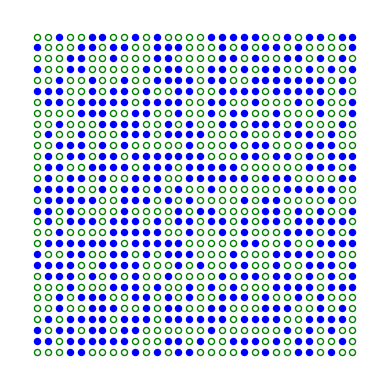

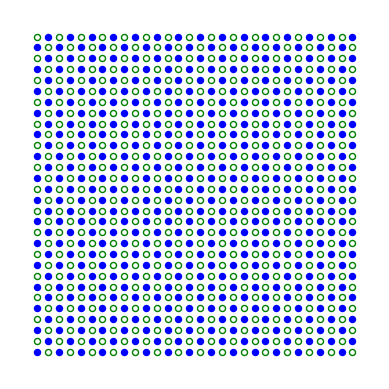

Visualization time: 0.0997 seconds
Algorithm initialization time: 0.0001 seconds
Move sequence calculation time: 0.1346 seconds

Total execution time: 0.2365 seconds
Number of moves: 286
[[(0, 2) -> (0, 1)], [(1, 5) -> (0, 4)], [(0, 4) -> (0, 3)], [(0, 6) -> (0, 7)], [(1, 13) -> (0, 13)], [(0, 16) -> (0, 15)], [(0, 20) -> (0, 21)], [(0, 26) -> (0, 27)], [(3, 3) -> (2, 2)], [(2, 2) -> (1, 2)], [(1, 7) -> (1, 6)], [(1, 11) -> (1, 10)], [(2, 12) -> (1, 13)], [(1, 13) -> (1, 14)], [(1, 17) -> (1, 16)], [(0, 18) -> (1, 18)], [(1, 19) -> (1, 20)], [(2, 26) -> (1, 26)], [(0, 28) -> (1, 28)], [(5, 1) -> (4, 1)], [(4, 1) -> (3, 1)], [(3, 1) -> (2, 1)], [(6, 2) -> (5, 1)], [(2, 4) -> (2, 5)], [(4, 12) -> (3, 11)], [(3, 11) -> (2, 10)], [(2, 10) -> (2, 9)], [(3, 13) -> (2, 13)], [(3, 17) -> (2, 16)], [(2, 16) -> (2, 15)], [(2, 18) -> (2, 19)], [(1, 21) -> (2, 21)], [(2, 24) -> (2, 25)], [(2, 28) -> (2, 27)], [(1, 29) -> (2, 29)], [(4, 2) -> (3, 2)], [(5, 7) -> (4, 6)], [(4, 6) -> (3, 6)], [(4, 8)

In [65]:
import time
from atommover.utils import PhysicalParams
from atommover.utils import AtomArray      
from atommover.algorithms import Hungarian

# Start timing
start_time = time.time()

# specifying parameters
load_prob = 0.5 # float; the probability that an individual site will be loaded
array_length = 30 # int; number of rows (or cols) of the square array

params = PhysicalParams(loading_prob = load_prob)

# Time array initialization
init_start = time.time()
atom_array_1 = AtomArray([array_length, array_length], 1, params)
init_time = time.time() - init_start
print(f"Array initialization time: {init_time:.4f} seconds")

# Time tweezer loading
load_start = time.time()
atom_array_1.load_tweezers()
load_time = time.time() - load_start
print(f"Tweezer loading time: {load_time:.4f} seconds")

# Time target generation
target_start = time.time()
atom_array_1.generate_target()
target_time = time.time() - target_start
print(f"Target generation time: {target_time:.4f} seconds")

# Time visualization
viz_start = time.time()
atom_array_1.image()
atom_array_1.plot_target_config()
viz_time = time.time() - viz_start
print(f"Visualization time: {viz_time:.4f} seconds")

# Time algorithm
algo_start = time.time()
algo1 = Hungarian()  
algo_init_time = time.time() - algo_start
print(f"Algorithm initialization time: {algo_init_time:.4f} seconds")

# Time move calculation
moves_start = time.time()
move_sequence = algo1.get_moves(atom_array_1)[1]
moves_time = time.time() - moves_start
print(f"Move sequence calculation time: {moves_time:.4f} seconds")

# Total time
total_time = time.time() - start_time
print(f"\nTotal execution time: {total_time:.4f} seconds")
print(f"Number of moves: {len(move_sequence) if move_sequence else 0}")
print(move_sequence)
print(move_sequence[1][0].from_row)

In [67]:
import spcm
from spcm import units

card : spcm.Card #Init card
with spcm.Card('/dev/spcm0') as card: 
    instance1 = Serial_AOD_2D_DDS(card, 1, 1, np.linspace(100,101,30), np.linspace(100,101,30))
    instance1.rearrange(move_sequence)  
    instance1.wait()


Moving from [100.0 100.06896551724138] MHz to [100.0 100.03448275862068] MHz
Duration per segment: 0.5 s
Moving from [100.03448275862068 100.17241379310344] MHz to [100.0 100.13793103448276] MHz
Duration per segment: 0.5 s
Moving from [100.0 100.13793103448276] MHz to [100.0 100.10344827586206] MHz
Duration per segment: 0.5 s
Moving from [100.0 100.20689655172414] MHz to [100.0 100.24137931034483] MHz
Duration per segment: 0.5 s
Moving from [100.03448275862068 100.44827586206897] MHz to [100.0 100.44827586206897] MHz
Duration per segment: 0.5 s
Moving from [100.0 100.55172413793103] MHz to [100.0 100.51724137931035] MHz
Duration per segment: 0.5 s
Moving from [100.0 100.6896551724138] MHz to [100.0 100.72413793103448] MHz
Duration per segment: 0.5 s
Moving from [100.0 100.89655172413794] MHz to [100.0 100.93103448275862] MHz
Duration per segment: 0.5 s
Moving from [100.10344827586206 100.10344827586206] MHz to [100.06896551724138 100.06896551724138] MHz
Duration per segment: 0.5 s
Movi

In [36]:
import numpy as np
a = np.array([1,2,3])   
b = np.array([4,5,6])   
output = np.outer(a,b)
print(output)   

d = b*units.MHz 
print(d)
print(d.magnitude)

[[ 4  5  6]
 [ 8 10 12]
 [12 15 18]]
[4 5 6] MHz
[4 5 6]
